<div style="text-align: center; border: 2px solid gray; padding: 10px; margin: 10px auto; width: fit-content;">
<font color='gray'>AI in Petroleum Industry</font><br>
<font color='gray'>Final Project: Deep Neural Networks for Reservoir Production Forecasting</font><br><br>
By <font color='green'>Novin Nekuee</font> (403134029)  & <font color='green'>Soroosh Danesh</font> (810403045)<br>
<p>Dr. Emami & Eng. Nasiri</p>
</div>

<div style="border:2px solid rgb(204, 0, 0); margin: 0 auto; padding:15px; background-color:rgba(240, 248, 255, 0.21); text-align: justify; border-radius:8px; width:auto;">
Note: This is a Side Project
This notebook explores a Side Project as a supplemental experiment.

In this approach, statistical outliers were identified and removed from the dataset before the model training process began.

The main and final project, in which the model was trained on the complete dataset and achieved more accurate and robust results, can be found at the following link:

<a href="./outputs/Main-Project(Nevin Nekuee & Soroush Danesh).pdf">main-project(Trained on All Data)</a>
</div>

### 1. Importing Libraries

This cell imports all the essential Python libraries required for the project.


In [1]:
"""
Data Handling and Numerical Operations: pandas for managing data in DataFrames, numpy for efficient numerical array operations, and os for file path management.

Deep Learning: tensorflow and the keras API are imported for building, training, and evaluating the neural network. 
        This includes specific layers (Conv2D, Dense, Dropout), model components, and callbacks (EarlyStopping, ReduceLROnPlateau).

Data Preprocessing: scikit-learn is used for splitting the dataset into training and testing sets, and also MinMaxScaler for normalizing data.

Visualization: matplotlib.pyplot and seaborn are included for creating plots to visualize data and model results.

Image Processing: The PIL (Pillow) library is used to open and handle the TIFF image files.

Hyperparameter Tuning: optuna is imported to automate the hyperparameter optimization process.

Metrics: sklearn is used to calculate the metrics for the model.
"""

# Data Handling and Numerical Operations and Path Management
import pandas as pd
import numpy as np
import os

# Image Processing
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras import regularizers

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter Tuning
import optuna

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warning handler
import warnings
warnings.filterwarnings('ignore')

### 2. Loading the Dataset

This cell loads the tabular data from the `data.xlsx` file into a pandas DataFrame called data.

In [2]:
data = pd.read_excel('./assets/TermProject/Data/data.xlsx')
data.head()

,sample number,Month (2026),Initial Sw,Oil Rate (m3/day),Cumulative Oil (M m3)
0,1,1,0.25,980.04,0.000681
1,1,3,0.25,410.07,25.471000
2,1,5,0.25,397.78,49.735000
3,1,7,0.25,388.08,73.408000
4,1,9,0.25,379.36,96.928000


### 3. Data Exploration and Validation

This cell performs an initial exploratory data analysis (EDA) to understand the dataset's structure, quality, and statistical properties.

`.isna().sum()`: This command counts the total number of missing or null values in each column, which is essential for identifying data quality issues that need to be addressed.

In [3]:
data.isna().sum()

sample number             0
Month (2026)              0
Initial Sw               18
Oil Rate (m3/day)        18
Cumulative Oil (M m3)    19
dtype: int64

`.describe()`: This function generates a statistical summary for the numerical columns, including metrics like mean, standard deviation, and quartiles. It provides a quick overview of the data's distribution and scale.

In [4]:
data.describe()

,sample number,Month (2026),Initial Sw,Oil Rate (m3/day),Cumulative Oil (M m3)
count,6300.000000,6300.000000,6282.000000,6282.000000,6281.000000
mean,525.500000,6.000000,0.214938,1423.594093,197.630083
std,303.132813,3.415921,0.028712,2813.436016,501.371992
min,1.000000,1.000000,0.170000,-145.740000,0.000000
25%,263.000000,3.000000,0.190000,345.830000,16.166000
50%,525.500000,6.000000,0.210000,809.145000,85.372000
75%,788.000000,9.000000,0.240000,1423.175000,214.100000
max,1050.000000,11.000000,0.260000,25000.000000,6256.200000


`.info()`: This method offers a concise summary of the DataFrame, showing the data type of each column, the number of non-null entries, and memory usage. This is useful for verifying that data has been loaded with the correct types.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample number          6300 non-null   int64  
 1   Month (2026)           6300 non-null   int64  
 2   Initial Sw             6282 non-null   float64
 3   Oil Rate (m3/day)      6282 non-null   float64
 4   Cumulative Oil (M m3)  6281 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 246.2 KB


### 4. Data Preprocessing and Reshaping (For Numerical Data)

This cell prepares the tabular data to align with the project's requirements and the available image data.

First, to ensure consistency between the datasets, the DataFrame is filtered to include only samples up to sample number 756. This is because the porosity image maps were only available for these first 756 samples.

The original dataset is in a `long` format, with six rows for each sample number, corresponding to six different months. This structure is not suitable for our model, as each sample (represented by one set of input images) should correspond to a single row of target values. Therefore, we reshape the data to `wide` format using a pivot_table. This operation transforms the six rows into a single row for each sample, creating 12 distinct columns: `six for the Oil Rate and six for the Cumulative Oil at each time step.`

Finally, the preprocessed data is cleaned by simplifying column names and handling any missing values through imputation (filling them with the `column's mean`). The .head() of the final DataFrame is then displayed for validation.

While more advanced methods like KNNImputer could be used, the simpler approach of mean imputation was chosen. This was done for simplicity and to avoid needing to normalize the data once for imputation and then again later for the model.

In [6]:
df_filtered = data.copy()

data_pivot = df_filtered.pivot_table(
    index='sample number',
    columns='Month (2026)',
    values=['Initial Sw', 'Oil Rate (m3/day)', 'Cumulative Oil (M m3)']
)

data_pivot.columns = [f'{val}_{month}' for val, month in data_pivot.columns]
data_pivot.reset_index(inplace=True)

sw_cols = [col for col in data_pivot.columns if 'Initial Sw' in col]
data_pivot['Initial Sw'] = data_pivot[sw_cols[0]]
data_pivot.drop(columns=sw_cols, inplace=True)

for col in data_pivot.columns:
    if data_pivot[col].isnull().any():
        mean_val = data_pivot[col].mean()
        data_pivot[col].fillna(mean_val, inplace=True)

data_pivot.head()

,sample number,Cumulative Oil (M m3)_1,Cumulative Oil (M m3)_3,Cumulative Oil (M m3)_5,Cumulative Oil (M m3)_7,Cumulative Oil (M m3)_9,Cumulative Oil (M m3)_11,Oil Rate (m3/day)_1,Oil Rate (m3/day)_3,Oil Rate (m3/day)_5,Oil Rate (m3/day)_7,Oil Rate (m3/day)_9,Oil Rate (m3/day)_11,Initial Sw
0,1,0.000681,25.4710,49.735,73.408,96.928,119.580,980.04,410.07,397.78,388.08,379.36,371.30,0.25
1,2,0.003307,118.8300,218.460,302.950,378.490,444.910,4762.30,1828.00,1578.20,1385.00,1218.40,1088.80,0.23
2,3,0.001104,45.5290,87.461,127.690,167.110,204.590,1590.00,725.02,687.42,659.53,635.76,614.49,0.21
3,4,0.003663,138.6700,259.880,369.820,470.760,558.220,5274.30,2199.30,1987.10,1802.20,1628.10,1433.70,0.25
4,5,0.000214,9.7412,19.257,28.656,38.117,47.345,307.56,159.06,156.00,154.09,152.59,151.28,0.22


Now lets save our processed dataset for easy access and easy compare

In [7]:
data_pivot.to_csv('processed_tabular_data(1050 Data).csv', index=False)

The `.shape` attribute is used to view the final dimensions (rows and columns) of our processed data_pivot DataFrame.

The output reveals that `our dataset has 753 rows, not the 756` we started with. This indicates that three samples were completely missing from the original tabular data. To ensure our image data and tabular data are perfectly aligned, these three corresponding image samples must also be removed, which is handled in a later step.

In [8]:
data_pivot.shape

(1047, 14)

Finally, another check for missing values confirms that the pivoted and imputed data is clean and ready for the next stage.

In [9]:
data_pivot.isna().sum()

sample number               0
Cumulative Oil (M m3)_1     0
Cumulative Oil (M m3)_3     0
Cumulative Oil (M m3)_5     0
Cumulative Oil (M m3)_7     0
Cumulative Oil (M m3)_9     0
Cumulative Oil (M m3)_11    0
Oil Rate (m3/day)_1         0
Oil Rate (m3/day)_3         0
Oil Rate (m3/day)_5         0
Oil Rate (m3/day)_7         0
Oil Rate (m3/day)_9         0
Oil Rate (m3/day)_11        0
Initial Sw                  0
dtype: int64

### 5. Outlier Detection and Removal

This section details the process of identifying and handling statistical outliers within the dataset. This was performed as an experimental step to understand their impact on model performance.

##### 5-1. Visualizing Outliers with Boxplots

Before programmatically removing outliers, a boxplot is generated for all 12 target variables. This visualization helps in understanding the distribution of each variable and visually confirming the presence of outliers.

**Analysis of the Plot**

The boxplot displays the distribution for each target variable. The points that fall outside the whiskers of the boxes are considered statistical outliers. The plot clearly shows that several variables, particularly the Oil Rate and Cumulative Oil in later months, contain a number of these outlier points.

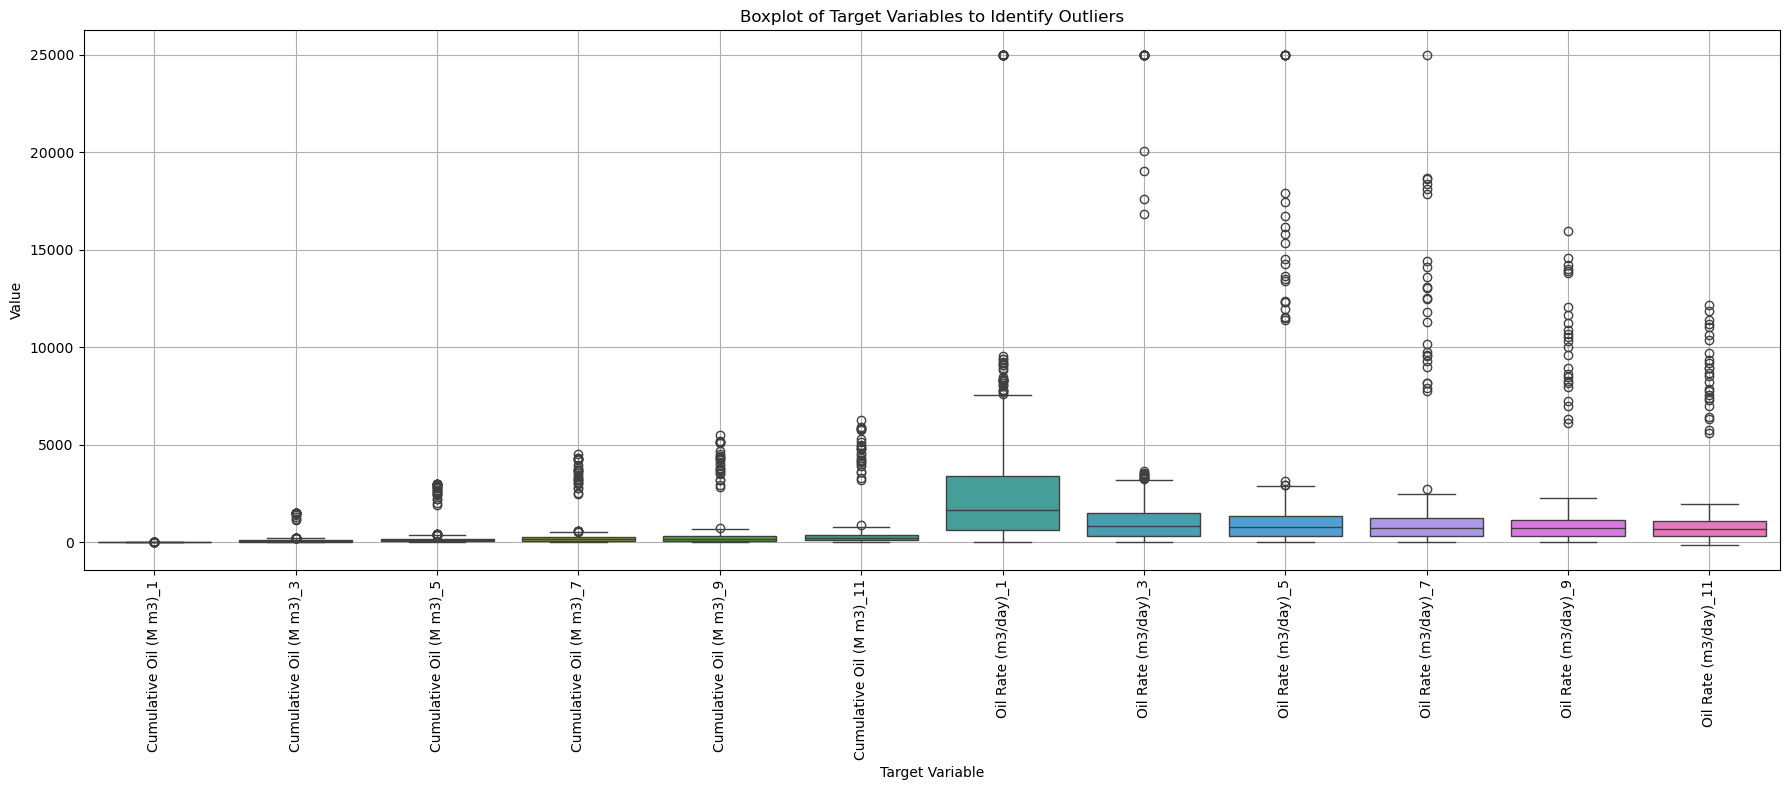

In [10]:
target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
df_targets_for_plot = data_pivot[target_cols]

plt.figure(figsize=(18, 8))
sns.boxplot(data=df_targets_for_plot)

plt.xticks(rotation=90)
plt.title('Boxplot of Target Variables to Identify Outliers')
plt.xlabel('Target Variable')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()

plt.show()

##### 5-2. Programmatic Outlier Removal using the IQR Method

Based on the visual confirmation from the boxplots, the next step is to programmatically identify and remove these outliers to create a `cleaned` dataset for one of the training experiments.

The standard Interquartile Range (`IQR`) method is used for this purpose. The code iterates through each of the 12 target columns, calculates the IQR for each, and defines the upper and lower bounds (`typically Q1 - 1.5*IQR and Q3 + 1.5*IQR`). Any sample that falls outside these bounds in any of the target variables is flagged as an outlier. Finally, all unique outlier samples are removed to create a new, cleaned DataFrame.

In [11]:
target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]

outlier_indices = set()

for col in target_cols:
    Q1 = data_pivot[col].quantile(0.25)
    Q3 = data_pivot[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    column_outliers = data_pivot[(data_pivot[col] < lower_bound) | (data_pivot[col] > upper_bound)].index
    
    outlier_indices.update(column_outliers)

outlier_list = list(outlier_indices)

print(f"Total number of unique outliers found across all 12 targets: {len(outlier_list)}")

print(f"\nOriginal DataFrame shape: {data_pivot.shape}")
data_pivot = data_pivot.drop(outlier_list)

print(f"DataFrame shape after removing all outliers: {data_pivot.shape}")

Total number of unique outliers found across all 12 targets: 50

Original DataFrame shape: (1047, 14)
DataFrame shape after removing all outliers: (997, 14)


##### 5-3. Verifying Outlier Removal

After programmatically removing the outliers using the IQR method, the boxplot is generated again on the new, cleaned DataFrame (`data_pivot`). The purpose of this step is to visually confirm the success of the outlier removal process.

**Analysis of the New Plot**

As the chart above clearly demonstrates, the individual data points that were previously scattered far beyond the whiskers are now gone. The removal of these extreme values has allowed the plot's y-axis to rescale, providing a much clearer and more detailed view of the distribution of the remaining, `typical` data.

This visualization successfully confirms that the statistical outliers have been removed, resulting in a cleaner and more concentrated dataset for the subsequent training experiment.

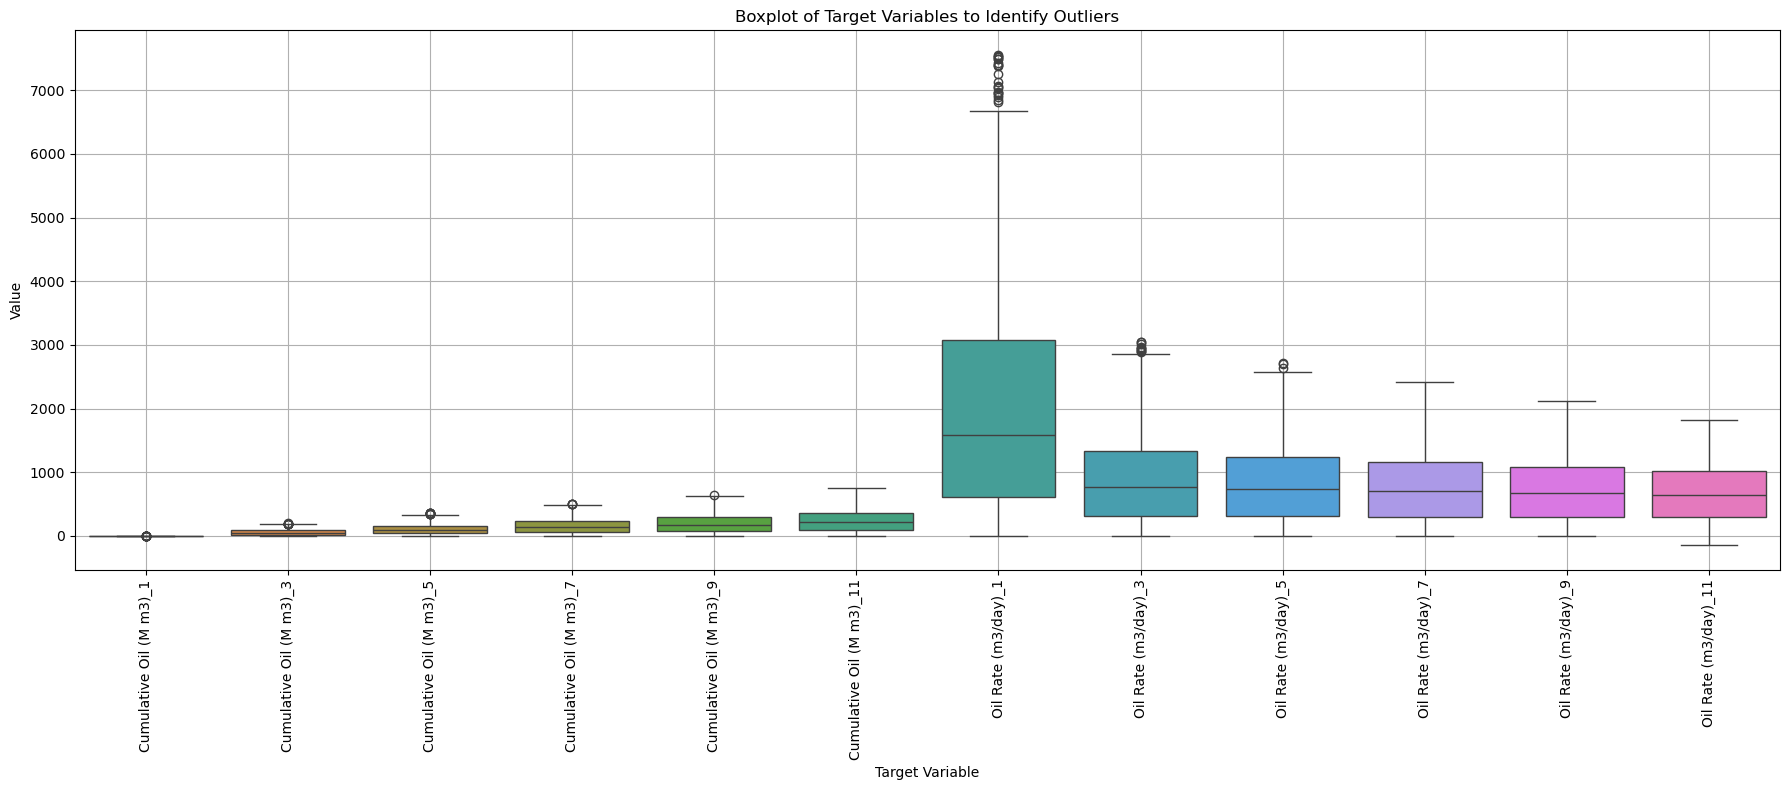

In [12]:
target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
df_targets_for_plot = data_pivot[target_cols]

plt.figure(figsize=(18, 8))
sns.boxplot(data=df_targets_for_plot)

plt.xticks(rotation=90)
plt.title('Boxplot of Target Variables to Identify Outliers')
plt.xlabel('Target Variable')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()

plt.show()

### 6. Loading and Stacking Image Data (Image Data)

This cell loads and processes the raw image data for the reservoir maps. The project requires two maps for each sample

The code iterates through the 756 sample numbers, loading each pair of permeability and porosity TIFF files. The two separate (64, 64) maps are then stacked along a new channel dimension using np.stack. This creates a single (64, 64, 2) array for each sample, where the first channel represents permeability and the second represents porosity.

Finally, all individual samples are combined into a single 4D NumPy array named image_data. The .shape attribute is called to verify the final dimensions of this array, which will be used as the image input for the model.

In [13]:
from gzip import BadGzipFile

FLOAT32_MAX = np.finfo(np.float32).max
BIG_THRESHOLD = 1e30

def sanitize_array(arr: np.ndarray, big_threshold: float = BIG_THRESHOLD) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    bad = (~np.isfinite(arr)) | (arr >= big_threshold) | (arr <= -big_threshold)
    # print(bad)
    if bad.any():
        arr[bad] = 0.0
    return arr

def load_two_channel_image(perm_path: str, poro_path: str) -> np.ndarray:
    perm_img = Image.open(perm_path)
    poro_img = Image.open(poro_path)

    perm_array = sanitize_array(np.array(perm_img))
    poro_array = sanitize_array(np.array(poro_img))

    return np.stack([perm_array, poro_array], axis=-1)

In [14]:
perm_folder = './assets/TermProject/Data/permeability/'
poro_folder = './assets/TermProject/Data/porosity/'

num_samples = 1050
all_images_list = []

for i in range(1, num_samples + 1):
    sample_id = str(i).zfill(4)

    perm_path = os.path.join(perm_folder, f'perm_map_{sample_id}.tiff')
    poro_path = os.path.join(poro_folder, f'poro_map_{sample_id}.tiff')

    img_2ch = load_two_channel_image(perm_path, poro_path)
    all_images_list.append(img_2ch)

image_data = np.array(all_images_list, dtype=np.float32)

image_data = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

print("Raw image_data sanity:",
      "finite=", np.isfinite(image_data).all(),
      "max=", image_data.max(),
      "min=", image_data.min())
print(image_data.shape)

Raw image_data sanity: finite= True max= 13485.833 min= 0.0
(1050, 64, 64, 2)


### 7. Aligning Tabular and Image Datasets

As identified in the data exploration step, our processed tabular DataFrame (data_pivot) contains 753 samples, while the initial image array was loaded with all 756 samples. This discrepancy means three samples present in the image folders were absent from the Excel file.

This cell resolves this issue to ensure the datasets are perfectly synchronized.

First, it extracts the list of `valid sample numbers` that exist in the final tabular data. These numbers are then converted to their corresponding zero-based array indices. Using this list of valid indices, the original `image_data` array is filtered, effectively removing the three images that do not have corresponding tabular data.

Finally, the synchronized datasets are separated into their final forms for the model: `X_image` (the filtered images), `X_numerical` (the 'Initial Sw' feature), and `y` (the 12 target variables). The shapes of these arrays are printed to confirm that they all now contain a consistent 753 samples.

In [15]:
valid_sample_numbers = data_pivot['sample number'].values

valid_indices = valid_sample_numbers - 1

X_image_filtered = image_data[valid_indices]

X_image = X_image_filtered

X_numerical = data_pivot['Initial Sw'].values.reshape(-1, 1)

target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
y = data_pivot[target_cols].values

print("Data Shapes:")
print(f" images data shape: {X_image.shape}")
print(f" numerical data shapes: {X_numerical.shape}")
print(f" Output shapes: {y.shape}")

Data Shapes:
 images data shape: (997, 64, 64, 2)
 numerical data shapes: (997, 1)
 Output shapes: (997, 12)


### 8. Creating Training, Validation, and Test Sets
This cell splits the complete dataset into three essential subsets for training and evaluating the deep learning model

- Training Set: The largest portion of the data, used to train the model's parameters.

- Validation Set: A separate subset used during training to monitor the model's performance on unseen data, which helps in tuning hyperparameters and preventing overfitting.

- Test Set: A final, completely unseen subset that is used only once after all training and tuning is complete to provide an unbiased evaluation of the final model's performance.

While it's possible to have Keras create a validation set automatically using the `validation_split` argument within `model.fit()`, we have chosen to create an explicit validation set beforehand. This approach is preferred for process clarity, ensuring that all three datasets are explicitly defined before training begins.

The split is performed in two steps. First, 20% of the data is held back as the test set. The remaining 80% is then split again. To ensure the validation set is 20% of the original total data, we must allocate 25% of the remaining data block for it `(since 0.20 / 0.80 = 0.25)`. This results in a final data distribution of `60% for training, 20% for validation, and 20% for testing`.

The shapes of all three final datasets are printed to verify the dimensions.

In [16]:
X_train_img, X_test_img, X_train_num, X_test_num, y_train0, y_test = train_test_split(
    X_image, X_numerical, y,
    test_size=0.2,
    random_state=42
)

X_train_image, X_val_image, X_train_number, X_val_number, y_train, y_val = train_test_split(
    X_train_img, X_train_num, y_train0,
    test_size=0.25, 
    random_state=42
)

X_train_image = X_train_image.astype(np.float32, copy=False)
X_val_image   = X_val_image.astype(np.float32, copy=False)
X_test_img    = X_test_img.astype(np.float32, copy=False)
X_train_number= X_train_number.astype(np.float32, copy=False)
X_val_number  = X_val_number.astype(np.float32, copy=False)
X_test_num    = X_test_num.astype(np.float32, copy=False)
y_train       = y_train.astype(np.float32, copy=False)
y_val         = y_val.astype(np.float32, copy=False)
y_test        = y_test.astype(np.float32, copy=False)

print("\nTraining Data shape:")
print(f" images data shape: (X_train_image): {X_train_image.shape}")
print(f" numerical data shapes (X_train_number): {X_train_number.shape}")
print(f" Output shapes (y_train): {y_train.shape}")
print("-" * 50)

print("\nValidation Data shape:")
print(f" images data shape: (X_val_image): {X_val_image.shape}")
print(f" numerical data shapes (X_val_number): {X_val_number.shape}")
print(f" Output shapes (y_val): {y_val.shape}")
print("-" * 50)

print("\nTest Data shape:")
print(f" images data shape: (X_test_img): {X_test_img.shape}")
print(f" numerical data shapes (X_test_num): {X_test_num.shape}")
print(f" Output shapes (y_test): {y_test.shape}")


Training Data shape:
 images data shape: (X_train_image): (597, 64, 64, 2)
 numerical data shapes (X_train_number): (597, 1)
 Output shapes (y_train): (597, 12)
--------------------------------------------------

Validation Data shape:
 images data shape: (X_val_image): (200, 64, 64, 2)
 numerical data shapes (X_val_number): (200, 1)
 Output shapes (y_val): (200, 12)
--------------------------------------------------

Test Data shape:
 images data shape: (X_test_img): (200, 64, 64, 2)
 numerical data shapes (X_test_num): (200, 1)
 Output shapes (y_test): (200, 12)


This cell prints the minimum and maximum values for each of the unscaled train, validation, and test sets. The purpose is to observe and understand the different scales of our input (image, numerical) and output (target) data before applying normalization.

As the output demonstrates, the value ranges for the image data and the target variables are significantly larger than the range of the numerical input `(Initial Sw)`. This large discrepancy confirms the need for normalization. To ensure all features contribute effectively during model training and to improve numerical stability, we will apply a `MinMaxScaler` to all datasets.

In [17]:
print("Training Input (Image) before Scaling:")
print(X_train_image.max())
print(X_train_image.min())
print(X_test_img.max())
print(X_test_img.min())
print(X_val_image.max())
print(X_val_image.min())
print("-" * 50)
print("\nTraining Input (Numerical) before Scaling:")
print(X_train_number.max())
print(X_train_number.min())
print(X_test_num.max())
print(X_test_num.min())
print(X_val_number.max())
print(X_val_number.min())
print("-" * 50)
print("\nTarget Output before Scaling:")
print(y_train.max())
print(y_train.min())
print(y_test.max())
print(y_test.min())
print(y_val.max())
print(y_val.min())


Training Input (Image) before Scaling:
10000.0
0.0
277.761
0.0
277.737
0.0
--------------------------------------------------

Training Input (Numerical) before Scaling:
0.26
0.17
0.26
0.17
0.26
0.17
--------------------------------------------------

Target Output before Scaling:
7543.1
-145.74
7429.7
1.01861e-06
7555.9
4.123e-07


### 9. Normalizing the Datasets

This cell normalizes all training, validation, and test sets to a consistent [0, 1] range. A crucial best practice is followed: the scaling parameters (e.g., min and max values) are learned only from the training data and then applied to transform all three subsets (train, validation, and test). This prevents any data leakage from the test and validation sets into the training process.

<div style="border:2px solid #007acc; padding:15px; background-color:rgba(240, 248, 255, 0.21); text-align:center; border-radius:8px; width:auto;">
The correct methodology for scaling is to fit the scaler only on the training data and then use that same fitted scaler to transform the training, validation, and test sets. This is critical because the training process should have no knowledge of the test set, which simulates new, unseen data. Applying scaling separately to each set is incorrect as it would create an inconsistent transformation based on different min/max values. <font color='red'>This method follows a crucial machine learning principle to prevent data leakage.</font>
</div>

<u>**Scaling Tabular Data**</u> (Targets and Numerical Inputs)

For the target variables (y) and the numerical input (X_numerical), the standard MinMaxScaler from scikit-learn is used. Separate scaler objects are fit on the training data (y_train, X_train_number) and then used to transform the corresponding train, validation, and test sets.

<u>**Scaling Image Data**</u>

For the 4D image data, the min-max scaling logic is applied manually. This approach was chosen over using the MinMaxScaler object directly for two main reasons:

- Efficiency: For large, multi-dimensional NumPy arrays, direct vectorized operations are often more computationally efficient.

- Simplicity: It avoids the need to reshape the 4D image data into a 2D array to be compatible with the scikit-learn scaler and then reshape it back.

The scaling is performed per-channel, meaning the min/max for the permeability channel is calculated and applied separately from the porosity channel. This preserves the unique statistical distribution of each physical property. The cell concludes by printing the min/max values of all scaled datasets to verify that the normalization was successful.

$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

You can see the scaled max and min data for each splitted data as a result:

In [18]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

num_scaler = MinMaxScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_number)
X_val_num_scaled   = num_scaler.transform(X_val_number)
X_test_num_scaled  = num_scaler.transform(X_test_num)

eps = 1e-8

perm_min = np.nanmin(X_train_image[:, :, :, 0])
perm_max = np.nanmax(X_train_image[:, :, :, 0])
den0 = (perm_max - perm_min) if (perm_max - perm_min) > 0 else eps

X_train_image[:, :, :, 0] = (X_train_image[:, :, :, 0] - perm_min) / den0
X_val_image[:,   :, :, 0] = (X_val_image[:,   :, :, 0] - perm_min) / den0
X_test_img[:,    :, :, 0] = (X_test_img[:,    :, :, 0] - perm_min) / den0

poro_min = np.nanmin(X_train_image[:, :, :, 1])
poro_max = np.nanmax(X_train_image[:, :, :, 1])
den1 = (poro_max - poro_min) if (poro_max - poro_min) > 0 else eps

X_train_image[:, :, :, 1] = (X_train_image[:, :, :, 1] - poro_min) / den1
X_val_image[:,   :, :, 1] = (X_val_image[:,   :, :, 1] - poro_min) / den1
X_test_img[:,    :, :, 1] = (X_test_img[:,    :, :, 1] - poro_min) / den1

X_train_img_scaled = np.clip(np.nan_to_num(X_train_image, nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)
X_val_img_scaled   = np.clip(np.nan_to_num(X_val_image,   nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)
X_test_img_scaled  = np.clip(np.nan_to_num(X_test_img,    nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)

def report(name, arr):
    print(f"{name:>20} | shape={arr.shape} | finite={np.isfinite(arr).all()} | "
          f"min={np.nanmin(arr):.6g} | max={np.nanmax(arr):.6g}")

print("\n=== Sanity checks ===")
report("X_train_img_scaled", X_train_img_scaled)
report("X_val_img_scaled",   X_val_img_scaled)
report("X_test_img_scaled",  X_test_img_scaled)
report("X_train_num_scaled", X_train_num_scaled)
report("X_val_num_scaled",   X_val_num_scaled)
report("X_test_num_scaled",  X_test_num_scaled)
report("y_train_scaled",     y_train_scaled)
report("y_val_scaled",       y_val_scaled)
report("y_test_scaled",      y_test_scaled)

print("Huge values >1e10 (train/val/test):",
      np.sum(X_train_img_scaled > 1e10),
      np.sum(X_val_img_scaled   > 1e10),
      np.sum(X_test_img_scaled  > 1e10))


=== Sanity checks ===
  X_train_img_scaled | shape=(597, 64, 64, 2) | finite=True | min=0 | max=1
    X_val_img_scaled | shape=(200, 64, 64, 2) | finite=True | min=0 | max=0.999992
   X_test_img_scaled | shape=(200, 64, 64, 2) | finite=True | min=0 | max=1
  X_train_num_scaled | shape=(597, 1) | finite=True | min=0 | max=1
    X_val_num_scaled | shape=(200, 1) | finite=True | min=0 | max=1
   X_test_num_scaled | shape=(200, 1) | finite=True | min=0 | max=1
      y_train_scaled | shape=(597, 12) | finite=True | min=0 | max=1
        y_val_scaled | shape=(200, 12) | finite=True | min=5.5562e-05 | max=1.0017
       y_test_scaled | shape=(200, 12) | finite=True | min=0.00017131 | max=0.984966
Huge values >1e10 (train/val/test): 0 0 0


Also you can see the scaled values below:

In [19]:
print("Training Input (Image) after Scaling:")
print(f" maximum X_train image data: {X_train_img_scaled.max()}")
print(f" minimum X_train image data: {X_train_img_scaled.min()}")
print(f" maximum X_test image data: {X_test_img_scaled.max()}")
print(f" minimum X_test image data: {X_test_img_scaled.min()}")
print(f" maximum X_val image data: {X_val_img_scaled.max()}")
print(f" minimum X_val image data: {X_val_img_scaled.min()}")
print("-" * 50)
print("\nTraining Input (Numerical) after Scaling:")
print(f" maximum X_train numerical data: {X_train_num_scaled.max()}")
print(f" minimum X_train numerical data: {X_train_num_scaled.min()}")
print(f" maximum X_test numerical data: {X_test_num_scaled.max()}")
print(f" minimum X_test numerical data: {X_test_num_scaled.min()}")
print(f" maximum X_val numerical data: {X_val_num_scaled.max()}")
print(f" minimum X_val numerical data: {X_val_num_scaled.min()}")
print("="*50)
print("Target output after Scaling:")
print(f" maximum y_train output data: {y_train_scaled.max()}")
print(f" minimum y_train output data: {y_train_scaled.min()}")
print(f" maximum y_test output data: {y_test_scaled.max()}")
print(f" minimum y_test output data: {y_test_scaled.min()}")
print(f" maximum y_val output data: {y_val_scaled.max()}")
print(f" minimum y_val output data: {y_val_scaled.min()}")

Training Input (Image) after Scaling:
 maximum X_train image data: 1.0
 minimum X_train image data: 0.0
 maximum X_test image data: 1.0
 minimum X_test image data: 0.0
 maximum X_val image data: 0.9999920129776001
 minimum X_val image data: 0.0
--------------------------------------------------

Training Input (Numerical) after Scaling:
 maximum X_train numerical data: 0.9999998807907104
 minimum X_train numerical data: 0.0
 maximum X_test numerical data: 0.9999998807907104
 minimum X_test numerical data: 0.0
 maximum X_val numerical data: 0.9999998807907104
 minimum X_val numerical data: 0.0
Target output after Scaling:
 maximum y_train output data: 1.0
 minimum y_train output data: 0.0
 maximum y_test output data: 0.9849660396575928
 minimum y_test output data: 0.0001713101810310036
 maximum y_val output data: 1.001697063446045
 minimum y_val output data: 5.556199903367087e-05


### 10. Visualizing Feature Correlations

This cell calculates and visualizes the Pearson correlation matrix for all numerical features in the dataset.

While this analysis is often a step towards feature selection, that is not the objective here, as the intention is to use all available features in the model. Instead, the primary purpose of this step is for exploratory data analysis. By creating a heatmap of the correlations, we can visually understand the strong intrinsic relationships between the input feature (Initial Sw) and the various output targets, as well as the relationships among the target variables themselves.

The heatmap displays these relationships, with warmer colors (red) indicating a strong positive correlation and cooler colors (blue) indicating a strong negative correlation. Finally, the specific correlation values for the `Initial Sw`(as only numerical input feature) feature are printed out for a more direct numerical analysis.

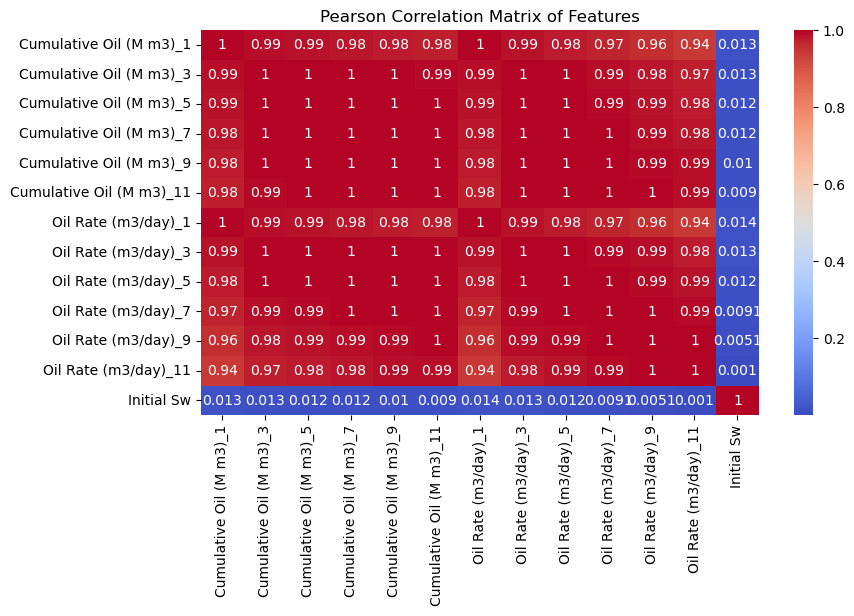


Correlation of 'Initial Sw' with Production Data
                          Initial Sw
Initial Sw                  1.000000
Oil Rate (m3/day)_1         0.013577
Cumulative Oil (M m3)_1     0.013387
Oil Rate (m3/day)_3         0.013278
Cumulative Oil (M m3)_3     0.012574
Cumulative Oil (M m3)_5     0.012463
Oil Rate (m3/day)_5         0.012173
Cumulative Oil (M m3)_7     0.011596
Cumulative Oil (M m3)_9     0.010319
Oil Rate (m3/day)_7         0.009144
Cumulative Oil (M m3)_11    0.009019
Oil Rate (m3/day)_9         0.005093
Oil Rate (m3/day)_11        0.001007


In [20]:
correlation_matrix = data_pivot.drop('sample number', axis=1).corr(method='pearson')

plt.figure(figsize=(9, 5))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm',
    annot=True 
)
plt.title('Pearson Correlation Matrix of Features')
plt.show()

print("\nCorrelation of 'Initial Sw' with Production Data")
print(pd.DataFrame(correlation_matrix['Initial Sw'].sort_values(ascending=False)))

<img src= "./assets/nn.png">

### 11. Building the Final Optimized Model

This cell defines the final, optimized Keras model architecture using the best hyperparameters discovered by the Optuna search in the previous step. The optimal parameters from the best trial are hardcoded into the model's layers for this definitive version.

The architecture consists of:

- A deep, four-layer Convolutional Neural Network (CNN) branch to extract complex spatial features from the 2-channel input maps.
- A small Dense branch to process the single numerical input feature.
- A concatenation layer that merges the outputs from the CNN and Dense branches.
- A final Dense block with strong regularization (both L2 and Dropout) to interpret the combined features.
- An output layer with 12 linear units to produce the final regression predictions for the 12 target variables.

Finally, model.summary() is called to print a detailed summary of the final architecture.

We used Optuna HyperParameter Optimization to find the best HyperParameters. We find this parameters metioned below:

<div style="border:2px solid rgb(204, 0, 0); margin: 0 auto; padding:15px; background-color:rgba(240, 248, 255, 0.21); text-align:center; border-radius:8px; width:350px;">
Best trial:<br>
  Value (minimized val_loss): 0.004182<br>
  Best Parameters: <br>
    filters_c1: 32<br>
    filters_c2: 64<br>
    filters_c3: 150<br>
    filters_c4: 200<br>
    dense_units: 128<br>
    dropout_rate: 0.22900252867496643<br>
    l2_factor: 0.007089910795610233<br>
    learning_rate: 0.00035324361573002924<br>
    optimizer: Nadam<br>
</div>

In [ ]:
# Optuna Hyper Parameter Tuning Best Result in 100 trials
"""
[I 2025-08-03 10:56:41,979] Trial 47 finished with value: 0.004181728232651949 and parameters: {'filters_c1': 32, 'filters_c2': 64, 
'filters_c3': 150, 'filters_c4': 200, 'dense_units': 128, 'dropout_rate': 0.22900252867496643, 'l2_factor': 0.007089910795610233, 
'learning_rate': 0.00035324361573002924, 'optimizer': 'Nadam'}. Best is trial 47 with value: 0.004181728232651949.
""" # 91- 93%

"""[I 2025-08-15 17:00:02,301] Trial 43 finished with value: 0.003772062947973609 and parameters: {'filters_c1': 32, 
'filters_c2': 100, 'filters_c3': 200, 'filters_c4': 200, 'dense_units': 64, 'dropout_rate': 0.26351223201335966, 'l2_factor': 0.001289882618282182, 
'learning_rate': 0.0005486346253058494, 'optimizer': 'Nadam'}. Best is trial 43 with value: 0.003772062947973609.
"""  # 90%

image_input = Input(shape=(64, 64, 2), name='image_input')
cnn = Conv2D(filters=32, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(image_input)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=64, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=150, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=200, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn_flatten = Flatten()(cnn)

numerical_input = Input(shape=(1,), name='numerical_input')
dense_num = Dense(units=8, activation='selu', kernel_initializer='lecun_normal')(numerical_input)

combined_features = concatenate([cnn_flatten, dense_num])
final_dense = Dense(units=128, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(0.007089910795610233))(combined_features) #0.001
final_dense = Dropout(0.22900252867496643)(final_dense)

output = Dense(units=12, activation='linear', name='output')(final_dense)

model = Model(inputs=[image_input, numerical_input], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        608 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     86,550 │ max_pooling2d_1[… │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 150) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 200) │    270,200 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3200)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         16 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3208)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    410,752 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 12)        │      1,548 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 788,170 (3.01 MB)

 Trainable params: 788,170 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

### 12. Defining Callbacks and Compiling the Model

This cell prepares the model for training by defining essential callbacks and compiling it with the optimal learning configuration.

Callbacks

Two key Keras callbacks are defined to monitor and control the training process:

- **EarlyStopping**: This callback stops the training automatically if the validation loss (val_loss) does not improve for a specified number of epochs (patience=15). Crucially, restore_best_weights=True ensures that the model's final weights are reverted to those from the epoch with the lowest validation loss, preventing overfitting.

- **ReduceLROnPlateau**: This acts as an adaptive learning rate scheduler (Performance learning schedule). It reduces the learning rate by a factor of 10 if the validation loss stagnates for 10 epochs, allowing the model to make finer adjustments as it approaches a solution.

Model Compilation

The `model.compile()` method configures the model for training with the following settings:

- **Optimizer**: The Adam optimizer is selected, using the optimal learning_rate discovered by the Optuna search.

- **Loss Function**: mean_squared_error is chosen, as it is a standard loss function for regression tasks.

- **Metrics**: In addition to the loss, the model will also track and report the Mean Absolute Error (mae) and Root Mean Squared Error (rmse) during training.

In [22]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005486346253058494), # 1e-3
    loss='mean_squared_error',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        tf.keras.metrics.RootMeanSquaredError(name='rmse')
    ]
)

### 13. Training the Model

This cell executes the main training loop for the compiled Keras model.

The `model.fit()` function trains the model on the scaled training data (`X_train_..._scaled` and `y_train_scaled`). The `validation_data` is also provided, allowing the model to evaluate its performance on unseen data at the end of each epoch.

The training is set to run for a maximum of 150 epochs with a batch size of 32. The `EarlyStopping` and `ReduceLROnPlateau` callbacks, defined in the previous cell, are passed to the training process to monitor performance and prevent overfitting. The results of the training, such as the loss and metrics for each epoch, are stored in the `history` object for later analysis and visualization.

In [23]:
epochs = 200
batch_size = 32

history = model.fit(
    x={'image_input': X_train_img_scaled, 'numerical_input': X_train_num_scaled},
    y=y_train_scaled,
    validation_data=(
        {'image_input': X_val_img_scaled, 'numerical_input': X_val_num_scaled}, 
        y_val_scaled
    ),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 5.0188 - mae: 1.0979 - rmse: 1.9231 - val_loss: 1.0184 - val_mae: 0.2778 - val_rmse: 0.3385 - learning_rate: 5.4863e-04
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.9942 - mae: 0.2363 - rmse: 0.3033 - val_loss: 0.9259 - val_mae: 0.1474 - val_rmse: 0.1856 - learning_rate: 5.4863e-04
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.9291 - mae: 0.1602 - rmse: 0.2038 - val_loss: 0.8992 - val_mae: 0.1229 - val_rmse: 0.1556 - learning_rate: 5.4863e-04
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.9025 - mae: 0.1407 - rmse: 0.1791 - val_loss: 0.8878 - val_mae: 0.1433 - val_rmse: 0.1782 - learning_rate: 5.4863e-04
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.8839 - mae: 0.1424 - rmse: 0.1808 - val_loss: 0.8545 - val_mae: 0.1075 - val_rmse: 0.1379 - learning_rate: 5.4863e-04
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.8563 - mae: 0.1256 - rmse: 0.1613 - va

### 14. Final Model Evaluation on the Test Set

This cell evaluates the performance of the final trained model on the completely unseen test set.

- **Prediction**: The `model.predict()` method is called on the scaled test inputs (`X_test_..._scaled`) to generate predictions. <font color="red">These initial predictions are in the normalized [0, 1] range.</font>

- **Inverse Scaling**: To make the results interpretable, the `y_scaler` object (which was fit on the original training data) is used. Its `.inverse_transform()` method converts both the model's scaled predictions and the scaled true target values (`y_test_scaled`) back to their original physical units.

- **Metric Calculation**: Standard regression metrics—Mean Absolute Error (`MAE`), Mean Squared Error (`MSE`), Root Mean Squared Error (`RMSE`), and R-squared (`R²`)—are calculated by comparing the un-scaled predictions against the un-scaled true values.

In [24]:
y_pred_scaled = model.predict({
    'image_input': X_test_img_scaled,
    'numerical_input': X_test_num_scaled
})

y_test = y_scaler.inverse_transform(y_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MAE  = 99.4274
MSE  = 49035.1523
RMSE = 221.4388
R²   = 0.9178


### 15. Visualizing Training History

This cell uses matplotlib to create a plot of the model's training and validation loss over each epoch.

The loss values are extracted from the history object, which was returned by the model.fit() function. Plotting these two curves on the same graph is a critical step for diagnosing the model's behavior. It allows for a visual inspection of how the model learned over time and helps confirm that the training was successful and free from significant overfitting or underfitting. The plot is given a title, axis labels, and a legend for clarity.

**The key observations from this chart are**:

- Healthy Learning Trend: Both the training loss (loss) and the validation loss (val_loss) show a strong, consistent downward trend. The most significant improvements occur in the initial epochs, followed by a period of steady fine-tuning.

- Excellent Convergence: Both the training loss (loss) and the validation loss (val_loss) decrease sharply and smoothly, eventually converging to a very low error value. This indicates the model learned the data efficiently and effectively.

- No Signs of Overfitting: Crucially, the validation loss consistently tracks the training loss without diverging or increasing. The small, stable gap between the two curves is ideal and indicates that the model is generalizing well to new, unseen data. If the model were overfitting, the validation loss would start to increase while the training loss continued to decrease.

- Well-Balanced Model: The minimal and stable gap between the two curves is the hallmark of a well-balanced model that generalizes very well to unseen data.

- Conclusion: This plot demonstrates a well-balanced and successful training process. The model has learned effectively without memorizing the training data, resulting in a final model that is neither overfit nor underfit.


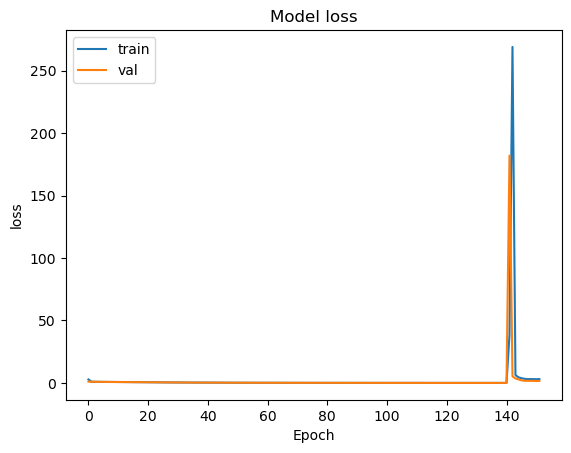

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel ('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 16. Model Validation and Visualization

After training the final model, this section focuses on a deep visual analysis of its performance on the unseen test set.

##### 16-1. Visual Analysis: `Actual vs. Predicted` Plots

The charts below show the `Actual vs. Predicted` results for all 12 target variables from this experimental model.

At first glance, these plots appear to have less scatter compared to the plots from the main model (which was trained on all data). The data points seem more concentrated. However, a closer inspection, particularly in the plots corresponding to larger production values, reveals that the model's predictions tend to be lower than the actual values (the points often fall below the red line).

This suggests that because the model was not trained on the high-value data that was flagged as outliers, its accuracy is lower when predicting these larger values.

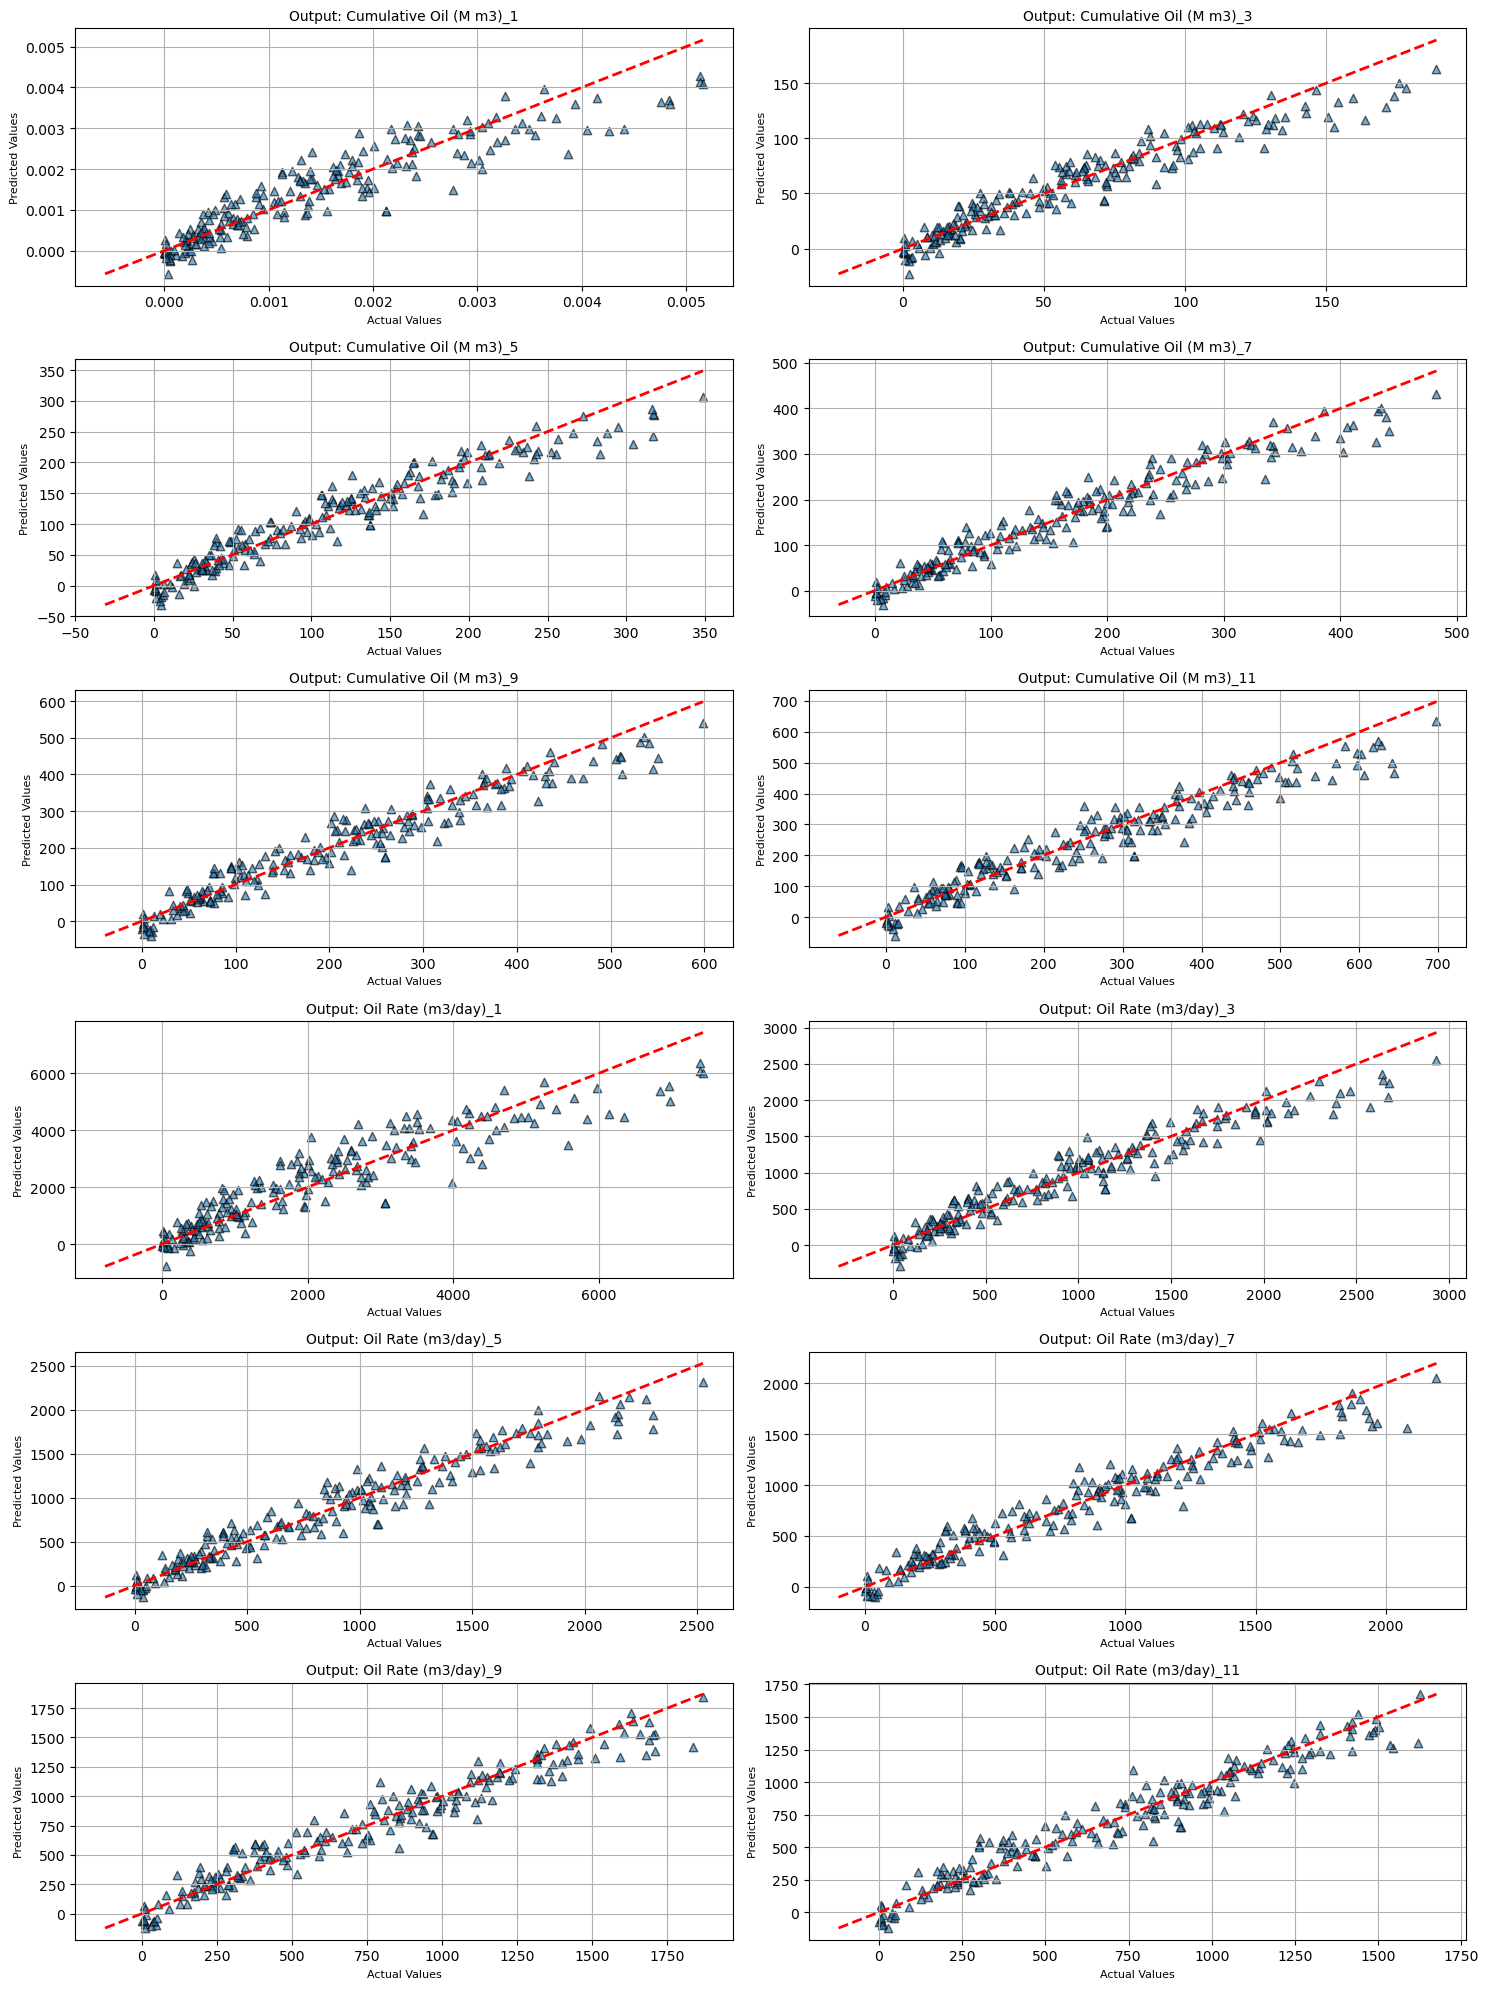

In [26]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    actual_data = y_test[:, i]
    predicted_data = y_pred[:, i]
    
    ax.scatter(actual_data, predicted_data, alpha=0.6, edgecolors='k', marker="^")

    if 'target_cols' in locals():
        ax.set_title(f'Output: {target_cols[i]}', fontsize=10)
    else:
        ax.set_title(f'Output Variable #{i+1}', fontsize=10)
        
    ax.set_xlabel('Actual Values', fontsize=8)
    ax.set_ylabel('Predicted Values', fontsize=8)
    ax.grid(True)
    
    min_val = min(actual_data.min(), predicted_data.min())
    max_val = max(actual_data.max(), predicted_data.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.tight_layout()

plt.show()

##### 16-2. Analyzing Residual Plots to Identify Outlier Impact

These charts show the residuals for the experimental model (the one trained on data after outliers were removed). This analysis further confirms the previous conclusion that the main model, trained on all data, is the more robust and reliable choice.

**Analysis of the Plots**

At first glance, because the extreme outlier samples have been removed, the vertical scatter of the errors in these plots appears smaller, and most points are contained within a tighter band around the zero-error line.

However, the distribution of the remaining residuals is not as perfectly random and patternless as it was for the main model. The subtle patterns in the scatter suggest that this experimental model, by not being exposed to the challenging outlier data during training, has not learned the underlying physical relationships as robustly as the main model.

Therefore, this final analysis reinforces the decision that the model trained on the complete dataset is the superior and more trustworthy model for this project.

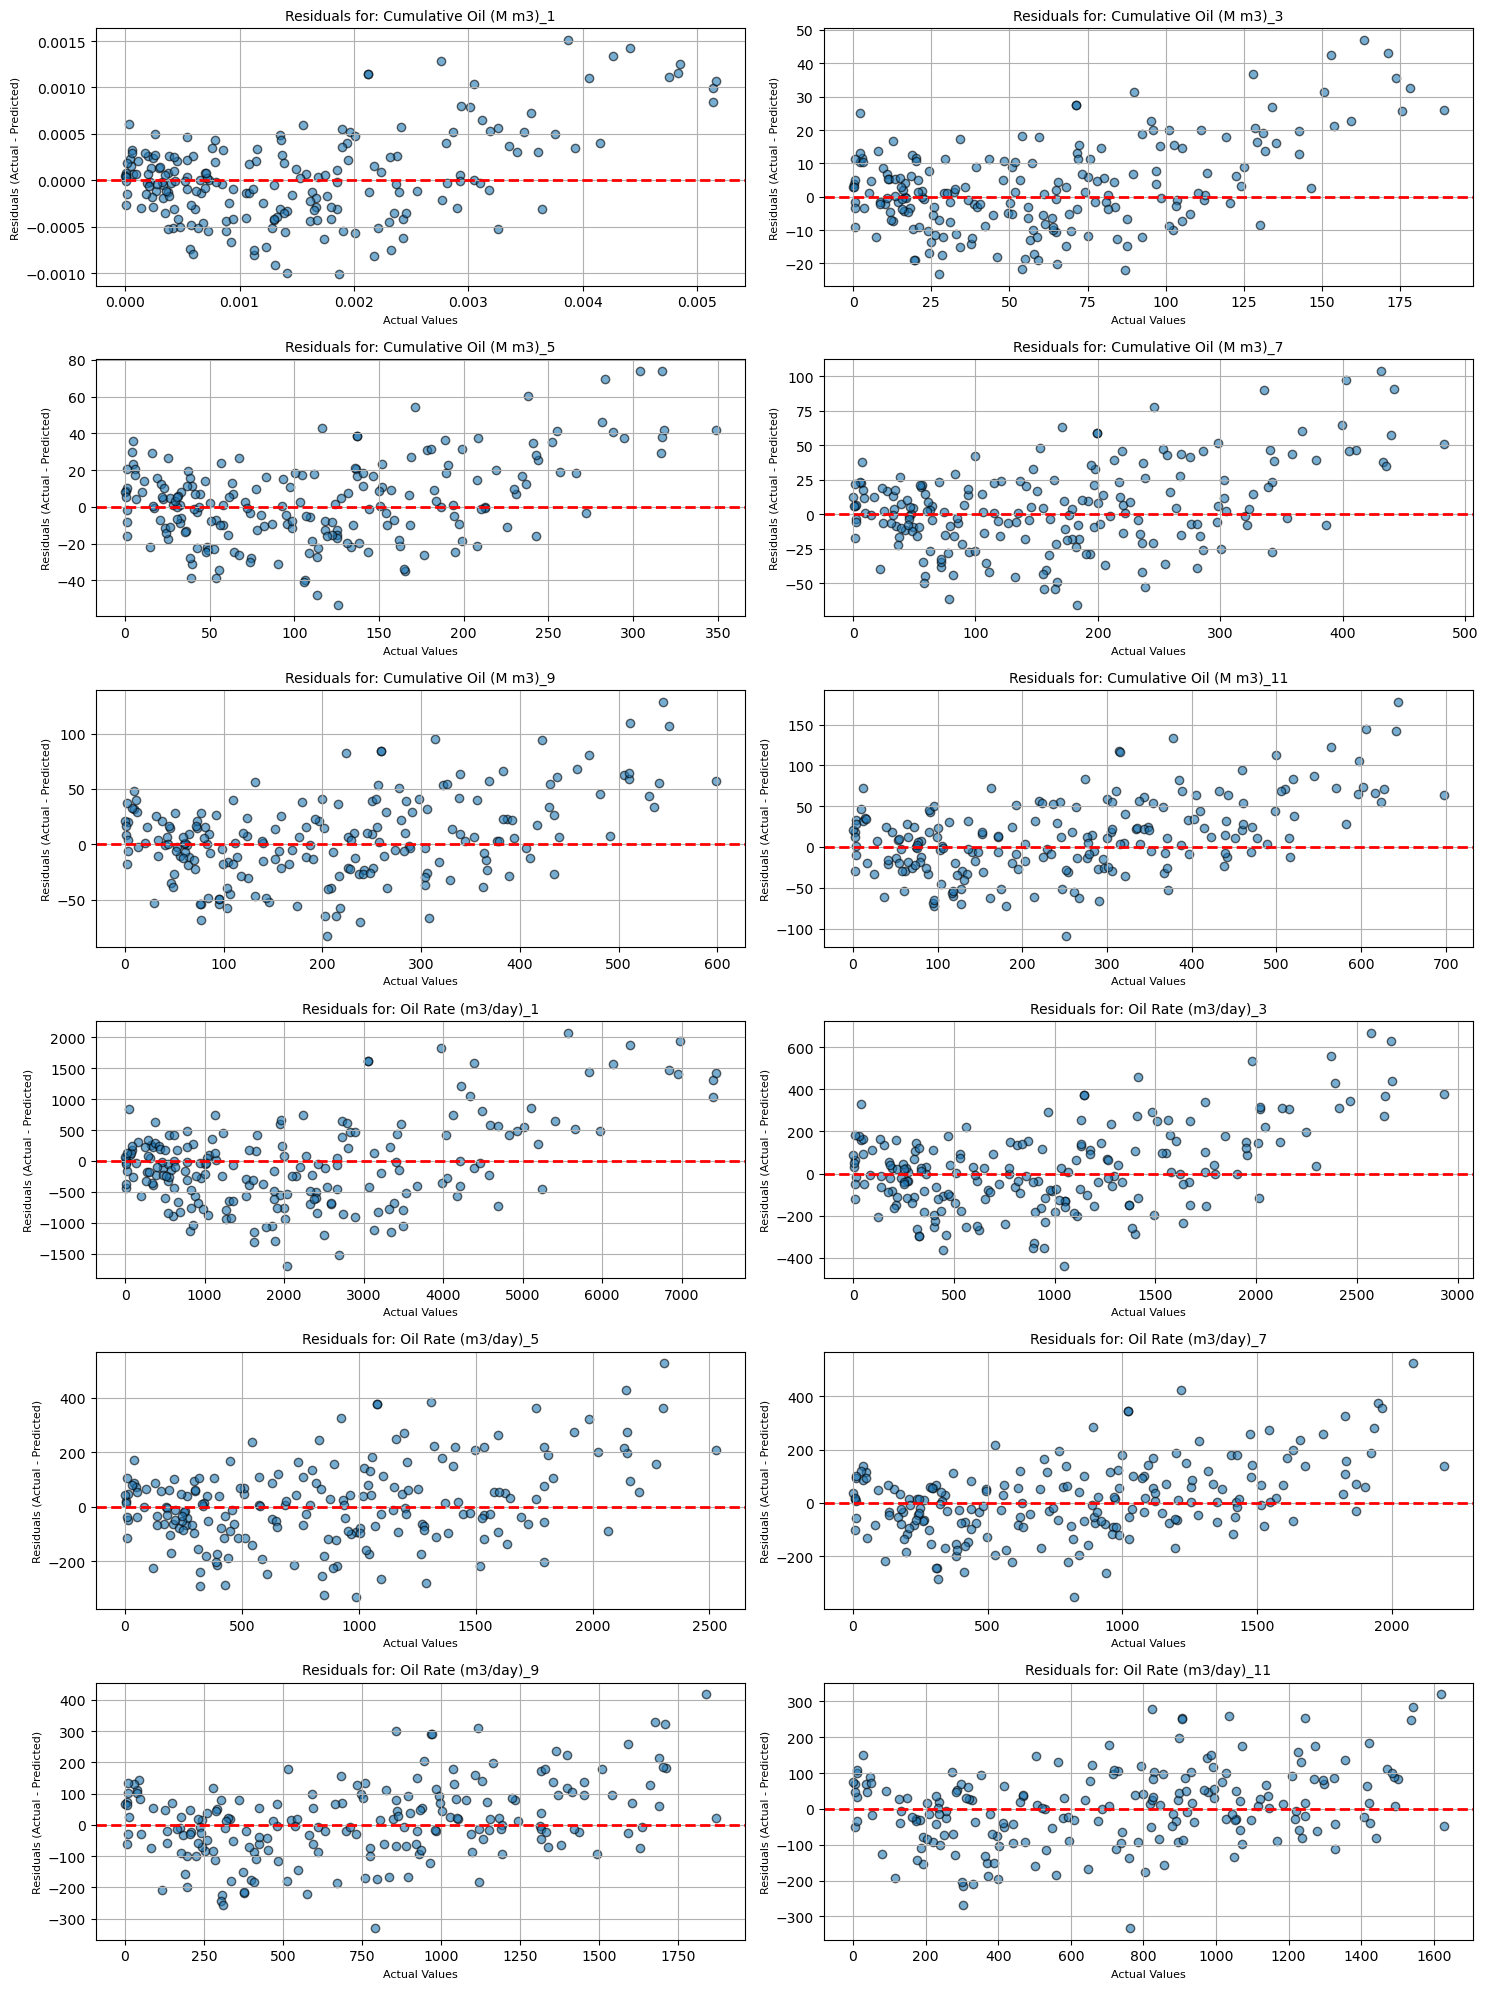

In [27]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    actual_data = y_test[:, i]
    predicted_data = y_pred[:, i]
    
    residuals = actual_data - predicted_data
    
    ax.scatter(actual_data, residuals, alpha=0.6, edgecolors='k')
    
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    
    if 'target_cols' in locals():
        ax.set_title(f'Residuals for: {target_cols[i]}', fontsize=10)
    else:
        ax.set_title(f'Residuals for Output #{i+1}', fontsize=10)
        
    ax.set_xlabel('Actual Values', fontsize=8)
    ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=8)
    ax.grid(True)

plt.tight_layout()

plt.show()

##### 16-3. Analysis of the Error Distribution

The histogram shows that the majority of the errors are correctly centered around zero, which is desirable. However, it is also clear that the distribution has `long tails`, indicating that even after removing the initial outliers, a number of predictions still have a significantly high error. This confirms that the inherent complexity of the problem leads to challenging predictions for certain samples, regardless of the initial data cleaning.

**Final Strategic Decision**

Based on the comprehensive analysis comparing the two modeling approaches, a final strategic decision was made:

1. Both approaches (the model trained on all data and the model trained on cleaned data) will be made available in the final `Streamlit` dashboard to allow for a complete comparison.

2. However, the model that was trained on the complete dataset, including all outliers, will be considered the primary reference model for this project.

The reason for this choice is that the primary model, despite being trained on more challenging data, ultimately achieved a higher overall accuracy (`97.5% (98.2%) vs 93.3%`). This demonstrates its superior ability to generalize and makes it a more robust and reliable tool for real-world scenarios where rare and unusual cases are expected.

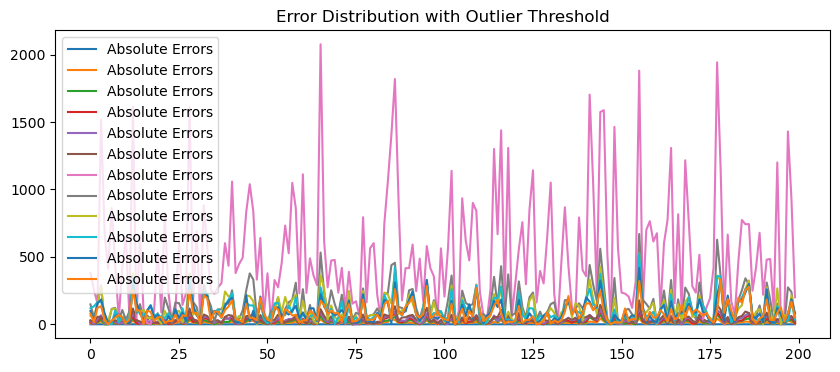

In [28]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(10, 4))
plt.plot(errors, label="Absolute Errors")
plt.title("Error Distribution with Outlier Threshold")
plt.legend()
plt.show()

##### 16-4. Case Study: Analyzing Predictions for a Single Sample

While aggregate metrics like `MAE` and `R²` provide a high-level view of performance, it's also insightful to inspect individual predictions to get a more concrete understanding of the model's behavior.

To achieve this, a single sample (`sample_index = 35`) was randomly selected from the test set. The code below iterates through all 12 target variables for this sample and prints a side-by-side comparison of the Actual (true) values and the Predicted values generated by the model.

This tabular view provides a tangible example of the model's performance on a case-by-case basis. It allows us to see the magnitude of the prediction error for each specific time step in its original, physical units, offering a more granular perspective on the errors that are summarized by the overall `MAE` and `RMSE` scores.

In [31]:
sample_index = 10

print("Output Name".ljust(30), "Actual".ljust(15), "Predicted")
print("-" * 60)

for i, name in enumerate(target_cols):
    actual_val = y_test[sample_index, i]
    predicted_val = y_pred[sample_index, i]
    print(f"{name.ljust(30)} {str(round(actual_val, 2)).ljust(15)} {round(predicted_val, 2)}")

Output Name                    Actual          Predicted
------------------------------------------------------------
Cumulative Oil (M m3)_1        0.0             0.0
Cumulative Oil (M m3)_3        38.78           40.880001068115234
Cumulative Oil (M m3)_5        73.87           77.25
Cumulative Oil (M m3)_7        107.28          120.91000366210938
Cumulative Oil (M m3)_9        139.89          138.9499969482422
Cumulative Oil (M m3)_11       170.85          176.8000030517578
Oil Rate (m3/day)_1            1307.6          1952.93994140625
Oil Rate (m3/day)_3            615.72          649.2999877929688
Oil Rate (m3/day)_5            575.25          569.52001953125
Oil Rate (m3/day)_7            547.67          573.8099975585938
Oil Rate (m3/day)_9            526.0           509.2900085449219
Oil Rate (m3/day)_11           507.62          496.05999755859375


##### 16-5. Performance Comparison and Conclusion

From above visuals the results are confirmed by the numerical results. This model achieved a final R² of `93.3%`, which is significantly lower than the `97.5%` accuracy of the main model trained on the complete dataset.

The reason for this is that by removing the outliers beforehand, the model was deprived of learning from realistic but rare high-production scenarios. As a result, its ability to generalize to these important edge cases was diminished.

Therefore, although this model's plots may appear `cleaner` at first glance, the results of the main model (trained on all data) are more reliable, more robust, and ultimately more accurate.

Even so, to complete the analysis of this experimental model, the corresponding residual and error distribution plots were also generated to gain a full understanding of its error behavior.

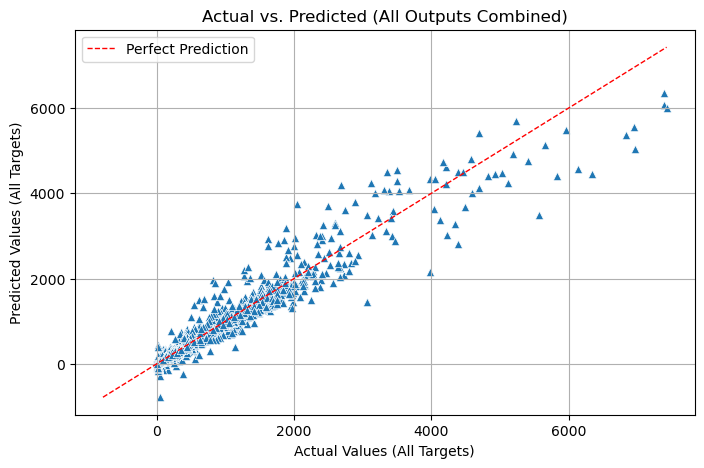

In [32]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, marker="^")

min_val = min(y_test_flat.min(), y_pred_flat.min())
max_val = max(y_test_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1, label='Perfect Prediction')

plt.title('Actual vs. Predicted (All Outputs Combined)')
plt.xlabel('Actual Values (All Targets)')
plt.ylabel('Predicted Values (All Targets)')
plt.legend()
plt.grid(True)
plt.show()

Now lets save our model for using it in our `Streamlit` dashboard

In [33]:
model.save("model_outlier_F.keras")

---

#### Attachements

This cell will show you the attachements and helper section to find the best results.

##### 1. Automated Hyperparameter Optimization with Optuna
To find the optimal combination of hyperparameters and achieve the highest possible model accuracy, the Optuna optimization framework was employed. This approach automates the complex and time-consuming process of manual tuning by performing an intelligent, guided search.

The mechanism is implemented as follows:

- Objective Function: The entire process of building, compiling, and training the model is encapsulated within an objective function. This function takes a trial object as an argument.

- Search Space Definition: Inside the objective function, a search space is defined for each hyperparameter (e.g., learning rate, dropout rate, number of filters in CNN layers, etc.). For each trial, the trial object suggests a new value for each parameter from its defined range.

- Training and Evaluation: The model is built and trained using the hyperparameters suggested by the current trial. At the end of training, the best validation loss (val_loss) is returned as the objective value.

- Optimization: Optuna runs the objective function for a predefined number of trials. It uses intelligent search algorithms to learn from the results of past trials, allowing it to focus on more promising regions of the hyperparameter space and efficiently converge toward the best possible combination.

This systematic approach allowed for the discovery of the optimal architecture and training parameters required to maximize the model's predictive accuracy.

A sample run of this optimization process is available in a Google Colab environment at the following link:

<a href="https://colab.research.google.com/drive/1r8HwFXH2dkc2POASA4GIX4o9gVbq3PMH#scrollTo=6410c0c8">Link to Colab</a>

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    filters_c1 = trial.suggest_categorical('filters_c1', [32, 50, 64])
    filters_c2 = trial.suggest_categorical('filters_c2', [64, 100, 128])
    filters_c3 = trial.suggest_categorical('filters_c3', [128, 150, 200])
    filters_c4 = trial.suggest_categorical('filters_c4', [200, 256, 300])

    dense_units = trial.suggest_categorical('dense_units', [64, 128, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.15, 0.4)
    l2_factor = trial.suggest_float('l2_factor', 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Nadam'])

    image_input = Input(shape=(64, 64, 2), name='image_input')
    cnn = Conv2D(filters=filters_c1, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(image_input)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c2, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c3, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c4, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)

    cnn_flatten = Flatten()(cnn)

    numerical_input = Input(shape=(1,), name='numerical_input')
    dense_num = Dense(units=8, activation='selu', kernel_initializer='lecun_normal')(numerical_input)

    combined_features = concatenate([cnn_flatten, dense_num])
    final_dense = Dense(units=dense_units, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(l2_factor))(combined_features)
    final_dense = Dropout(dropout_rate)(final_dense)

    output = Dense(units=12, activation='linear', name='output')(final_dense)
    model = Model(inputs=[image_input, numerical_input], outputs=output)

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

    history = model.fit(
        x={'image_input': X_train_img_scaled, 'numerical_input': X_train_num_scaled},
        y=y_train_scaled,
        validation_data=({'image_input': X_val_img_scaled, 'numerical_input': X_val_num_scaled}, y_val_scaled),
        epochs=150,
        batch_size=32,
        callbacks=[early_stopper],
        verbose=0
    )

    best_val_loss = min(history.history['val_loss'])
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\n" + "="*50)
print("Optuna Hyperparameter Tuning Finished.")
print("="*50)
print(f"Number of finished trials: {len(study.trials)}")
print("\nBest trial:")
best_trial = study.best_trial
print(f"  Value (minimized val_loss): {best_trial.value:.6f}")
print("  Best Parameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

##### 2. Saving the Training History
This code uses the pickle library to save the `history.history` dictionary, which contains the `loss` and `metrics` from each training epoch, into a file named `training_history_outlier.pkl`. This file is saved so that the training history can be loaded and visualized later in the `Streamlit` dashboard.

In [34]:
import pickle

history_filename = 'training_history_outlier_F.pkl'

with open(history_filename, 'wb') as file:
    pickle.dump(history.history, file)

print(f"Training history successfully saved to: {history_filename}")

Training history successfully saved to: training_history_outlier_F.pkl


##### 3. Generating Predictions for the Entire Dataset

As a final step, this cell runs the fully trained model on the entire dataset (`combining all training, validation, and test samples`). The goal is to generate a complete prediction set for every sample, which can be used for a comprehensive final review or for direct comparison with the original ground truth data.

The process involves the following steps:

- The saved Keras model and the fitted scaler objects are loaded from disk.

- The complete set of image and numerical inputs are scaled using these loaded objects to ensure consistent preprocessing.

- The `model.predict()` method is called on the entire prepared dataset.

- The scaled predictions are inverse-transformed back to their original, physical units.

- A final post-processing step clips any physically impossible negative predictions to zero.

The resulting predictions for all 12 target variables are then compiled into a pandas DataFrame and saved to an Excel file named `out_dataset_predictions.xlsx` for future analysis.

In [35]:
X_numerical_all = data_pivot['Initial Sw'].values.reshape(-1, 1)
sample_numbers = data_pivot['sample number'].values

model = tf.keras.models.load_model('model_outlier_F.keras')

X_numerical_scaled_all = num_scaler.transform(X_numerical_all)

X_image_scaled_all = X_image.copy()
if (perm_max - perm_min) != 0:
    X_image_scaled_all[:, :, :, 0] = (X_image_scaled_all[:, :, :, 0] - perm_min) / (perm_max - perm_min)
if (poro_max - poro_min) != 0:
    X_image_scaled_all[:, :, :, 1] = (X_image_scaled_all[:, :, :, 1] - poro_min) / (poro_max - poro_min)
X_image_scaled_all = np.nan_to_num(X_image_scaled_all)

y_pred_s = model.predict({
    'image_input': X_image_scaled_all,
    'numerical_input': X_numerical_scaled_all
})

predictions_original = y_scaler.inverse_transform(y_pred_s)

predictions_original[predictions_original < 0] = 0

target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
df_predictions = pd.DataFrame(predictions_original, columns=target_cols)
df_predictions.insert(0, 'sample number', sample_numbers)

pd.DataFrame(df_predictions).head()
df_predictions.to_excel('out_dataset_predictions_F.xlsx', index=False)
print("Predictions saved to 'out_dataset_predictions_F.xlsx'")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Predictions saved to 'out_dataset_predictions_F.xlsx'


You can see the result of predicting for entire dataset below:

In [36]:
pd.DataFrame(df_predictions).head()

,sample number,Cumulative Oil (M m3)_1,Cumulative Oil (M m3)_3,Cumulative Oil (M m3)_5,Cumulative Oil (M m3)_7,Cumulative Oil (M m3)_9,Cumulative Oil (M m3)_11,Oil Rate (m3/day)_1,Oil Rate (m3/day)_3,Oil Rate (m3/day)_5,Oil Rate (m3/day)_7,Oil Rate (m3/day)_9,Oil Rate (m3/day)_11
0,1,0.000670,28.536259,53.711998,76.775925,93.531570,113.154732,958.086670,472.912689,425.484680,404.333069,359.165436,364.624115
1,2,0.003145,115.203033,215.603928,305.773956,387.777435,431.796783,4733.716797,1750.951416,1669.362549,1410.329712,1281.336304,1184.363159
2,3,0.001303,50.604755,97.596573,138.973114,181.924149,214.274063,2113.641357,829.628662,811.377808,728.778564,695.112122,622.330566
3,4,0.003820,137.660767,261.951202,360.503235,450.137421,534.674622,5314.434082,2184.797607,1886.851685,1667.543335,1564.831177,1422.077393
4,5,0.000000,0.000000,0.000000,8.390587,14.900736,13.378028,0.000000,0.000000,99.997398,42.661083,71.447006,99.606262


Checking shape of dataset due to the errors which has been solved

In [37]:
print(X_numerical_all.shape)
print(sample_numbers.shape)
print(X_image_scaled_all.shape)

(997, 1)
(997,)
(997, 64, 64, 2)


##### 4. Saving Preprocessing Objects for the Dashboard

This cell uses the joblib library to save the trained scalers and calculated image scaling parameters to disk.

These saved files are essential for the `Live Prediction `feature of the Streamlit dashboard. The dashboard will load these objects to:

- Scale new user inputs (the uploaded images and the Initial Sw value) using the exact same parameters that were learned from the original training data.

- Inverse-transform the model's scaled predictions back into their real-world, interpretable units.

- The scale factors are not same to each other (First approach)

In [38]:
import joblib
image_scaling_params = {
    'perm_min_out': perm_min,
    'perm_max_out': perm_max,
    'poro_min_out': poro_min,
    'poro_max_out': poro_max
}
joblib.dump(y_scaler, 'y_scaler_out_F.gz')
joblib.dump(num_scaler, 'num_scaler_out_F.gz')
joblib.dump(image_scaling_params, 'image_param_out_F.gz')

['image_param_out_F.gz']